In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.f2py.crackfortran import verbose

np.set_printoptions(precision=3, suppress=True)

In [2]:
# Load the data
train = pd.read_csv('iitb-cs-725-1-2024/train.csv')
test = pd.read_csv('iitb-cs-725-1-2024/test.csv')
sample = pd.read_csv('iitb-cs-725-1-2024/sample.csv')

In [107]:
# Display the data
train.head()

,ID,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,score
0,0,0.040776,2.247366,0.486094,-1.791148,-0.260466,-0.693494,-0.007988,-0.390353,0.342489,...,0.116905,0.004497,0.045408,-0.160795,0.018927,0.038400,-0.224252,-0.095052,-0.060982,0.0
1,1,2.885314,-1.228567,-0.023254,1.243954,-0.276285,0.791822,-0.390133,0.048296,-0.007136,...,0.111936,-0.050685,-0.163769,-0.068437,0.082455,-0.013019,-0.052774,-0.042545,-0.027698,3.0
2,2,2.612578,0.978922,0.402049,0.628482,0.481488,-0.421969,-0.090971,-0.496587,0.314399,...,-0.066646,-0.092024,-0.078880,-0.005543,0.104462,0.136459,-0.064776,0.074138,0.030638,0.0
3,3,0.333623,0.658054,-0.747531,-0.505702,0.359609,0.459562,0.278906,0.078858,0.330526,...,0.121561,0.065324,0.114508,0.007231,0.055410,0.016136,-0.049182,-0.059409,-0.144704,3.0
4,4,-0.873343,-0.650602,0.336838,0.100677,-0.317427,-0.072732,-0.187683,0.493616,-0.234106,...,0.143080,0.051453,0.032550,-0.088987,0.003385,0.097682,-0.020679,-0.115271,-0.014201,3.0


In [4]:
train.describe()

,ID,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,score
count,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,...,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000
mean,17493.500000,-0.025667,0.005326,-0.015741,-0.004780,-0.008944,-0.004670,-0.018182,0.004407,-0.006715,...,-0.000510,0.000518,0.000264,-0.001224,0.001429,0.001177,0.000770,0.000382,0.000216,3.144707
std,10100.309946,3.030748,2.171696,0.909885,0.676247,0.625618,0.529283,0.490776,0.446237,0.411561,...,0.095402,0.093816,0.093434,0.091614,0.090396,0.089828,0.088973,0.087636,0.087134,1.162853
min,0.000000,-15.945959,-6.853446,-3.450916,-3.371233,-6.351802,-2.003163,-1.482526,-2.353964,-1.659474,...,-0.942247,-0.588330,-0.771596,-0.597644,-0.495204,-0.429300,-0.509795,-0.415701,-0.629959,0.000000
25%,8746.750000,-2.061522,-1.405245,-0.617246,-0.439032,-0.372987,-0.368630,-0.356968,-0.241367,-0.279038,...,-0.058841,-0.060398,-0.060151,-0.058916,-0.056803,-0.055921,-0.056793,-0.056750,-0.055648,3.000000
50%,17493.500000,0.230517,-0.278906,-0.073073,-0.033572,0.030238,-0.033410,-0.055696,0.040935,-0.012411,...,-0.000265,-0.000856,0.000478,-0.000103,0.002216,0.001734,0.000313,-0.000057,0.000577,4.000000
75%,26240.250000,2.271520,1.090409,0.530538,0.414171,0.409971,0.330293,0.281676,0.280784,0.260926,...,0.058520,0.059978,0.061082,0.057753,0.059987,0.058986,0.057766,0.057200,0.056666,4.000000
max,34987.000000,8.828334,20.064835,7.041929,4.111352,1.978701,2.511990,6.510805,8.411146,2.536084,...,0.975914,0.696887,0.532025,0.622193,0.452759,0.549956,0.471785,0.565583,0.621282,4.000000


In [5]:
# Check for missing values
train.isnull().sum()

ID            0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
             ..
feature_60    0
feature_61    0
feature_62    0
feature_63    0
score         0
Length: 66, dtype: int64

In [13]:
# Create datasets
def create_datasets(data):
    X = data.drop(['score', 'ID'], axis=1)
    y = data['score']
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    return X, y

# Shuffle the data
train = train.sample(frac=1).reset_index(drop=True)

n_train = int(0.9 * train.shape[0])
X_train, y_train = create_datasets(train[:n_train])
X_val, y_val = create_datasets(train[n_train:])

X_train.shape, X_val.shape

((31489, 64), (3499, 64))

In [110]:
# No. of features
N = X_train.shape[1]

# Weight vector (N x 1)
W = np.random.randn(N, 1)

In [76]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(N,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, input_shape=(N,))
])

model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
  1/875 ━━━━━━━━━━━━━━━━━━━━ 2:35 178ms/step - loss: 10.9344

/Users/amaljoe/Desktop/Workspace/IITB/FML/assignment1/venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - loss: 3.2019 - val_loss: 0.9124
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step - loss: 0.9180 - val_loss: 0.8635
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - loss: 0.8648 - val_loss: 0.8327
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - loss: 0.8300 - val_loss: 0.8150
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - loss: 0.8102 - val_loss: 0.8148
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - loss: 0.8063 - val_loss: 0.7958
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step - loss: 0.7995 - val_loss: 0.7955
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - loss: 0.7886 - val_loss: 0.7991
Epoch 9/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - loss: 0.7764 - val_loss: 0.7943
Epoch 10/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step - loss: 0.7928 - val_loss: 0.8037


In [107]:
import random

def predict(X, W):
    return X @ W

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def compute_gradients(X, y, y_pred):
    dW = -2 * X.T @ (y - y_pred) / X.shape[0]
    return dW

def fit(X, y, W, Xval, yval, lr=0.01, epochs=100, print_every=100, batch_size=32):
    # Error list
    errors = []
    val_errors = []
    best_val_error = float('inf')
    best_W = None
    
    for i in range(epochs):
        # Mini-batch gradient descent
        idx = random.sample(range(X.shape[0]), batch_size)
        X_batch, y_batch = X[idx], y[idx]
        y_pred = predict(X_batch, W)
        y_pred_round = y_pred.round()

        if i % print_every == 0 or i == epochs - 1:
            train_loss = mse(y, predict(X, W))
            y_val_pred = predict(Xval, W)
            val_loss = mse(yval, y_val_pred)
            Y_val_round = y_val_pred.round()
            Y_val_rounded_loss = mse(yval, Y_val_round)
            print(f'Epoch {i}, Loss: {train_loss}, Val Loss: {val_loss}, Rounded Val Loss: {Y_val_rounded_loss}')
            errors.append(train_loss)
            val_errors.append(val_loss)
            if val_loss < best_val_error:
                best_val_error = val_loss
                best_W = W
            if train_loss < 0.8 and val_loss < 0.87:
                print(f'Early stopping at epoch {i}, Loss: {train_loss}, Val Loss: {val_loss}')
                break
        
        dW = compute_gradients(X_batch, y_batch, y_pred_round)
        W -= lr * dW
        
        
    return best_W, errors, val_errors

In [6]:
# Closed form solution

from closedForm import LinearRegressionClosedForm

model = LinearRegressionClosedForm()

model.fit(X_train, y_train)

y_pred = model.predict(X_val)
rmse(y_val, y_pred)

3.2682933059181574

In [5]:
def plot_errors(errors, val_errors):
    plt.plot(errors, label='Train')
    plt.plot(val_errors, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
# Gradient Descent
W, errors, val_errors = fit(X_train, y_train, W, X_val, y_val, lr=0.0001, epochs=1000)

y_pred = predict(X_val, W)

plot_errors(errors, val_errors)

rmse(y_val, y_pred)

NameError: name 'W' is not defined

In [110]:
# Feature engineering

# Mean and variance
mu = np.mean(X_train)
sigma = np.std(X_train)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma)**2)

def normalize(X, mu, sigma):
    return (X - mu) / sigma

def relu(x):
    return np.maximum(0, x)

# Add polynomial features
def transform_input(X):
    X_new = X
    for i in range(-1, 1):
        j = i
        X_new = np.hstack([X_new, gaussian_basis(X, mu + j, sigma)])
    return X_new
        

X_train_poly = transform_input(X_train)
X_val_poly = transform_input(X_val)
print(X_train_poly.shape, X_val_poly.shape)

W_poly = np.random.randn(X_train_poly.shape[1], 1)

(31489, 192) (3499, 192)


In [11]:
W_poly = np.load('weights5.npy')

Epoch 0, Loss: 0.8939376687491218, Val Loss: 0.8698722453427313, Rounded Val Loss: 0.948556730494427
Epoch 30000, Loss: 0.8929320053372688, Val Loss: 0.8692244692917621, Rounded Val Loss: 0.9465561589025436
Epoch 60000, Loss: 0.8925326080432847, Val Loss: 0.8698841066325171, Rounded Val Loss: 0.9531294655615891
Epoch 90000, Loss: 0.8925428295884198, Val Loss: 0.8681331197881361, Rounded Val Loss: 0.9476993426693341
Epoch 120000, Loss: 0.8920606716102898, Val Loss: 0.8696597136390192, Rounded Val Loss: 0.9502715061446128
Epoch 150000, Loss: 0.8915347174610333, Val Loss: 0.8682482954769237, Rounded Val Loss: 0.9474135467276364
Epoch 180000, Loss: 0.8911671379047866, Val Loss: 0.8676751012748977, Rounded Val Loss: 0.9459845670191483
Epoch 210000, Loss: 0.8908797950916196, Val Loss: 0.8671448961065406, Rounded Val Loss: 0.9476993426693341
Epoch 240000, Loss: 0.8906352946268776, Val Loss: 0.8674741127599412, Rounded Val Loss: 0.9468419548442412
Epoch 270000, Loss: 0.8903830279547885, Val Lo

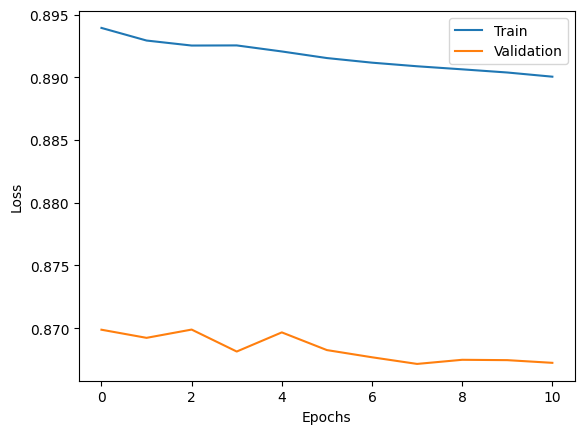

0.9451271791940554

In [113]:
epochs = 300000

W_train_poly, errors, val_errors = fit(X_train_poly, y_train, W_poly, X_val_poly, y_val, lr=0.0001, epochs=epochs, print_every=epochs/10, batch_size=32)

plot_errors(errors, val_errors)

y_pred = predict(X_val_poly, W_train_poly)
y_pred_round = y_pred.round()
mse(y_val, y_pred_round)

In [114]:
# export weights
np.save('weights6.npy', W_train_poly)
W_backup = W_train_poly

In [98]:
X_val_poly = transform_input(X_val)
y_pred = predict(X_val_poly, W_poly)

rmse(y_val, y_pred)

0.9318112443972046

In [100]:
# Get output for final test data
X_final_test = np.array(test.drop('ID', axis=1))
X_final_test_poly = transform_input(X_final_test)
y_final_test = predict(X_final_test_poly, W_poly)
y_final_test = y_final_test.round()

output = pd.DataFrame({'ID': test['ID'], 'score': y_final_test.flatten()})

# output['score'] = output['score'].clip(0, 5)

# count score < 0
below0 = output[output['score'] < 0].shape[0]

# count score > 5
above5 = output[output['score'] > 5].shape[0]

print(output.shape[0], below0, above5)

output.to_csv('output.csv', index=False)

14996 0 3


In [68]:
import tensorflow as tf

def gaussian_basis(x):
    # Mean and variance
    mu = np.mean(x)
    sigma = np.std(x)
    return np.exp(-0.5 * ((x - mu) / sigma)**2)

def normalize(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

# Add polynomial features
def transform_input(X, basis):
    transormed_X = np.hstack([basis[i](X) for i in range(len(basis))])
    transormed_X = np.hstack([X, transormed_X])
    return transormed_X

basis_funcs = [
    [normalize],
    [gaussian_basis],
    [sigmoid],
    [sigmoid, gaussian_basis, normalize],
]

for basis in basis_funcs:
    transformed_X_train = transform_input(X_train, basis)
    transformed_X_val = transform_input(X_val, basis)
    
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(transformed_X_train.shape[1],)),
        tf.keras.layers.Dense(1)
    ])
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse')
    model.fit(transformed_X_train, y_train, validation_data=(transformed_X_val, y_val), epochs=10, verbose=0)
    train_loss, val_loss = model.evaluate(transformed_X_train, y_train), model.evaluate(transformed_X_val, y_val)
    print(basis, train_loss, val_loss)

875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.8705
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step - loss: 0.8961
[<function normalize at 0x38ef3daf0>] 0.8870629668235779 0.8694994449615479
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.8607
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step - loss: 0.8802
[<function gaussian_basis at 0x3b3d63550>] 0.8777105212211609 0.8520484566688538
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.8657
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - loss: 0.8883
[<function sigmoid at 0x38375dee0>] 0.882866621017456 0.8620593547821045
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.8679
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step - loss: 0.8938
[<function sigmoid at 0x38375dee0>, <function gaussian_basis at 0x3b3d63550>, <function normalize at 0x38ef3daf0>] 0.8849837779998779 0.8647343516349792


In [40]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')
model.fit(transformed_X_train, y_train, validation_data=(transformed_X_val, y_val), epochs=10)

Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 1.3638 - val_loss: 1.0372
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step - loss: 0.9448 - val_loss: 0.9532
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step - loss: 0.9095 - val_loss: 0.9712
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - loss: 0.8788 - val_loss: 0.9324
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - loss: 0.8806 - val_loss: 0.8915
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - loss: 0.8550 - val_loss: 0.9437
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - loss: 0.8317 - val_loss: 0.8486
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - loss: 0.8230 - val_loss: 0.8512
Epoch 9/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - loss: 0.8435 - val_loss: 0.8431
Epoch 10/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step - loss: 0.8142 - val_loss: 0.8732


In [214]:
import tensorflow as tf

# Add polynomial features
def transform_input(X, basis):
    transormed_X = np.hstack([basis[i](X) for i in range(len(basis))])
    transormed_X = np.hstack([X, transormed_X])
    return transormed_X

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def gaussian_basis(x):
    # Mean and variance
    mu = np.mean(x)
    sigma = np.std(x)
    return np.exp(-0.5 * ((x - mu) / sigma)**2)

basis = [gaussian_basis]

transformed_X_train = transform_input(X_train, basis)
transformed_X_val = transform_input(X_val, basis)

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(transformed_X_train.shape[1],)),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_134 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129 (516.00 B)

 Trainable params: 129 (516.00 B)

 Non-trainable params: 0 (0.00 B)

In [215]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='mse')
model.fit(transformed_X_train, y_train, validation_data=(transformed_X_val, y_val), epochs=100)

Epoch 1/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 3.3207 - val_loss: 1.4445
Epoch 2/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - loss: 1.3784 - val_loss: 1.3350
Epoch 3/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - loss: 1.2782 - val_loss: 1.2485
Epoch 4/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - loss: 1.2242 - val_loss: 1.1806
Epoch 5/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 1.1312 - val_loss: 1.1279
Epoch 6/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - loss: 1.0916 - val_loss: 1.0818
Epoch 7/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 1.0511 - val_loss: 1.0465
Epoch 8/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - loss: 1.0085 - val_loss: 1.0163
Epoch 9/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step - loss: 0.9937 - val_loss: 0.9920
Epoch 10/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - loss: 0.9806 - val_loss: 0.9714
Epoch 11/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step - loss: 0.9652 - val_loss: 0.9547
Epoch 12/100
985/98

In [216]:
# RMSE
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(y_val, model.predict(transformed_X_val))
rmse.result().numpy()

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


0.93085057

0.92 current best rmse on val set submitted
0.87 ideally should be the best rmse on val set